<table>
<tr>
    <td width=10%><img src="./img/logo_lri.jpg"></td>
    <td width=30%><img src="./img/medi-chal_logo.png" height=15%></img></td>
</tr>

</table>

<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">
    Être ou ne pas être ?
</a></center>
<br/>
<center><a style="font-size: 22pt; font-weight: bold">
    Un problème de classification binaire sur des données médicales artificelles
<br/>

---

# Présentation du challenge

## La question principale de ce challenge est : 

* Comment prédire la survie d'un·e patient·e compte tenu de son dossier médical ? 
    
* Plus précisément, on doit prédire la survie des patient·e·s pendant leur séjour à l'hôpital
 
Chaque jour, le personnel soignant collecte de nombreuses informations sur les patient·e·s en posant des questions et en utilisant des outils de mesure (stéthoscope, analyse de sang, capteurs, etc.). Ces données sont très utiles pour surveiller l'état de santé, diagnostiquer et choisir les traitements.

Elles peuvent également être utilisées pour l'analyse statistique prédictive.

## Données

L'ensemble de données contient des informations sur 80'000 patient·e·s, représentés par des variables (descripteurs) catégorielles, binaires et numériques. Ces variables sont, par exemple, l'âge, le sexe, l'origine ethnique, l'état matrimonial, ainsi que des données médicales telles que la tension artérielle ou le taux de glucose. Il y a un total de 342 variables.

La classe (étiquette ou label) à prédire est une variable binaire indiquant si la·le patient·e est décédé·e ou non pendant son séjour à l'hôpital. Heureusement, la plupart survivent :

![](img/tobe.png)

## Tâche

La tâche consiste à créer un modèle capable d'apprendre à partir des données et de faire des prédictions (apprentissage supervisé). Chaque instance (patient·e) possède une variable indiquant si elle·il est décédé·e ou non pendant son séjour à l'hôpital.

Références et crédit :

Isabelle Guyon, Kristin Bennett, Andrew Yale, Adrien Pavao, Thomas Gerspacher

# Challenge

In [1]:
import platform
from datetime import datetime
from pathlib import Path

import imblearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn import (
    decomposition,
    discriminant_analysis,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
    preprocessing,
    svm,
)

In [2]:
if platform.system() == "Darwin":
    %config InlineBackend.figure_format="retina"  # For high DPI display

# Set precision for pd and np (np: suppress also sci notation)
np.set_printoptions(precision=3, suppress=True)
pd.options.display.float_format = "{:,.3g}".format

sns.set_style("darkgrid")
sns.set_context("notebook")

print(pd.__version__)       # 2.0.0
print(sklearn.__version__)  # 1.2.2

2.2.0
1.4.0


## 1. Chargement des données

In [3]:
DATA = Path("public_data")

PRED_PATH = Path("Submissions")

DROP_VARS = ["ADMITTIME", "DISCHTIME", "SUBJECT_ID", "HADM_ID"]

assert DATA.is_dir()

In [4]:
features = pd.read_csv(
    DATA / "mimic_synthetic_feat.name", header=None
).values.flatten()

labels = pd.read_csv(
    DATA / "mimic_synthetic_label.name", header=None
).values.flatten()

x_df = pd.read_csv(
    DATA / "mimic_synthetic_train.data",
    header=None,
    names=features,
    sep=" ",
)

# Remove variables that are not relevant
x_df.drop(columns=DROP_VARS, inplace=True)

ys = pd.Series(
    pd.read_csv(
        DATA / "mimic_synthetic_train.solution",
        header=None,
        names=labels,
        sep=" ",
    ).values.flatten()
)

In [5]:
print(x_df.shape)
x_df.head(3)

(79999, 337)


,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,GENDER,AGE,HR_MIN_DAY1,HR_MAX_DAY1,HR_MEAN_DAY1,...,Eyeinfectn,Othereyedx,Otitismedia,Dizziness,Othereardx,Othnervdx,Hrtvalvedx,Carditis,HTN,Htncomplicn
0,Private,ENGL,CATHOLIC,DIVORCED,WHITE,F,21,57.2,109,70.8,...,0,0,0,0,0,0,0,0,0,0
1,Private,ENGL,UNOBTAINABLE,SINGLE,WHITE,M,39,79.3,121,96.9,...,0,0,0,0,0,0,0,0,0,1
2,Medicaid,SPAN,CATHOLIC,WIDOWED,OTHER,M,40,118,175,141,...,0,0,0,0,0,0,0,0,0,0


## 2. Analyse exploratoire

#### Types des variables

In [6]:
types = pd.read_csv(DATA / "mimic_synthetic_feat.type", header=None).set_index(
    features
)[0]

types.value_counts()

0
Numerical      226
Binary         107
Categorical      8
Name: count, dtype: int64

#### Distribution de la variable cible

In [7]:
ys.describe()

count   8e+04
mean    0.035
std     0.184
min         0
25%         0
50%         0
75%         0
max         1
dtype: float64

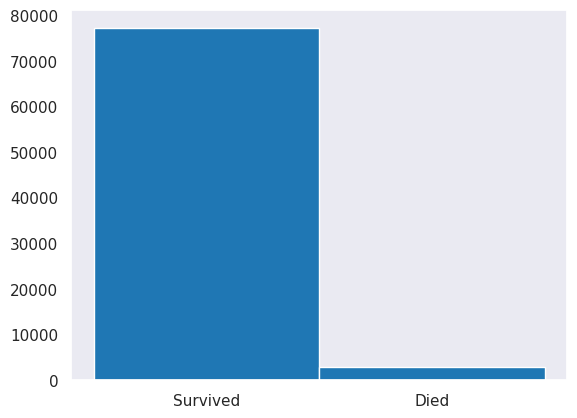

In [8]:
ys.hist(bins=2, grid=False, align="left")
plt.xticks([0, 0.5], ["Survived", "Died"])
plt.show()

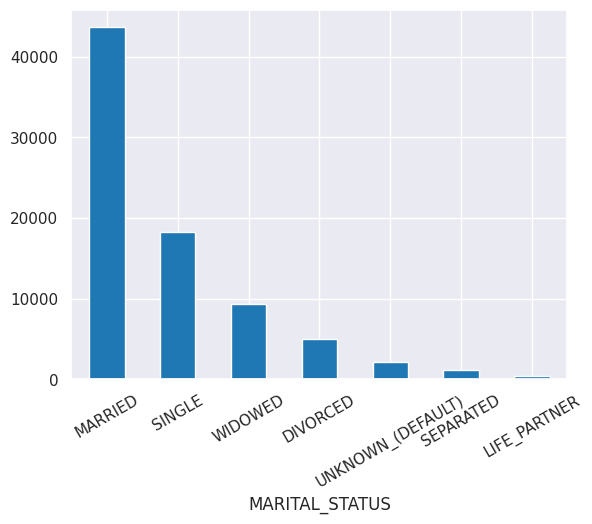

In [9]:
x_marital_cnts = x_df["MARITAL_STATUS"].value_counts()
x_marital_cnts.plot.bar(rot=30)
plt.show()

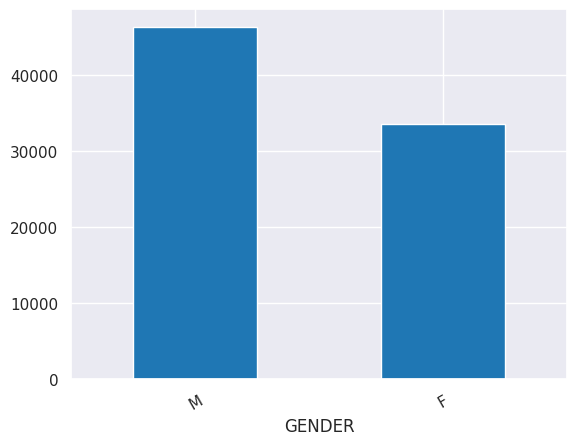

In [10]:
x_gender_cnts = x_df["GENDER"].value_counts()
x_gender_cnts.plot.bar(rot=30)
plt.show()

#### Corrélations

/home/karim/miniconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/karim/miniconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


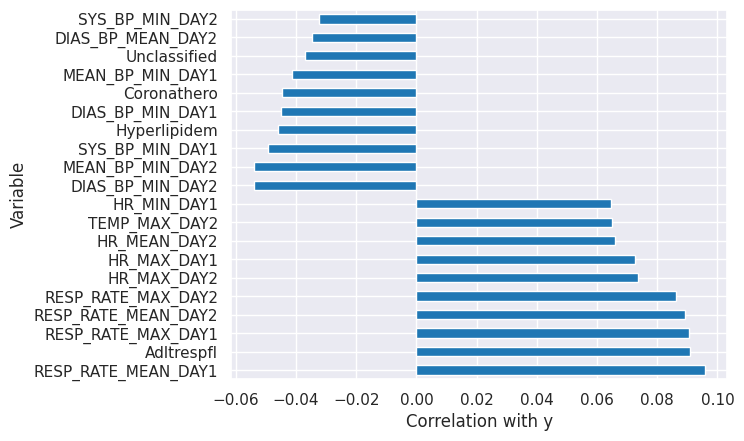

In [11]:
# Select only numeric columns
numeric_x_df = x_df.select_dtypes(include=[np.number])

correlations = numeric_x_df.corrwith(ys)
n_most_correlated = 10
most_correlated = pd.concat([correlations.nlargest(n_most_correlated), correlations.nsmallest(n_most_correlated)])

most_correlated.plot.barh()
plt.xlabel("Correlation with y")
plt.ylabel("Variable")
plt.show()


## 3. Pre-traitement

### Traitement du problème des valeurs manquantes (ou non définies, NAN)

La solution la plus simple est d'éliminer l'ensemble des colonnes où il y a des données manquantes, mais on perd de l'information. 

Vu le faible nombre d'instances concernées (maximum 6 : voir ci-dessous) il parait plus pertinent de supprimer les lignes (instances) plutôt que les colonnes entières (variables).

La solution que J'ai choisis ici est une troisième, celle de remplacer les valeurs non définies par la valeur la plus probable de la variable.

In [12]:
print(x_df.shape)

(79999, 337)


In [13]:
x_nans = x_df.isna().sum()
x_miss = x_nans[x_nans > 0]
x_miss

LANGUAGE                              1
MARITAL_STATUS                        1
ICU                                   2
ECodes:Adverseeffectsofmedicalcare    6
Otnutritdx                            2
Othnervdx                             1
dtype: int64

In [14]:
x_miss_rows = x_df.isna().any(axis="columns")

x_df.loc[x_miss_rows, x_miss.index]

,LANGUAGE,MARITAL_STATUS,ICU,ECodes:Adverseeffectsofmedicalcare,Otnutritdx,Othnervdx
2251,ENGL,MARRIED,MICU,NaN,0,0
9983,ENGL,MARRIED,MICU,0,NaN,0
10549,ENGL,MARRIED,MICU,0,NaN,0
10831,ENGL,MARRIED,MICU,NaN,1,0
17012,ENGL,MARRIED,CSRU,NaN,0,1
23088,ENGL,MARRIED,NaN,0,0,0
32539,ENGL,NaN,CSRU,0,0,0
42762,ENGL,SINGLE,TSICU,NaN,0,0
53191,NaN,MARRIED,MICU,0,0,0
53390,CAPE,MARRIED,NaN,0,0,0


#### Remplacement des NAN

In [15]:
na_cols = set(x_miss.index) 

for col in na_cols:
    x_df[col].fillna(x_df[col].mode()[0], inplace=True)


/tmp/ipykernel_1366750/2077302878.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  x_df[col].fillna(x_df[col].mode()[0], inplace=True)


In [16]:
print(
    x_df.isna().any().any(),
    sep="\n",
)

False


In [17]:
print(x_df.shape)

(79999, 337)


### Gestion des catégories rares

Simplifier les données en regroupant par exemple les catégories rares.

In [18]:
def merge_rare_categories(dfs, col, keeps=None, keep_n=5):
    if keeps is None:
        keeps = x_df[col].value_counts()[:keep_n].index
        print(keeps)

    for df in dfs:
        df.loc[~df[col].isin(keeps), col] = "OTHER"


merge_rare_categories([x_df], col="RELIGION", keep_n=5)

Index(['CATHOLIC', 'NOT_SPECIFIED', 'UNOBTAINABLE', 'PROTESTANT_QUAKER',
       'JEWISH'],
      dtype='object', name='RELIGION')


In [19]:
merge_rare_categories([x_df], col="LANGUAGE", keep_n=5)

Index(['ENGL', 'SPAN', 'RUSS', 'PTUN', 'CANT'], dtype='object', name='LANGUAGE')


### Transformation des données catégorielles en nombres entiers

Les variables catégorielles sont présentées sous forme de chaines de caractères. La plupart des modèles ne pourront pas les prendre en entrée.

In [20]:
def label_encode(df, only_binary=False):
    """
    Select categorical variables and encode them in integers.
    """
    char_cols = df.dtypes.pipe(lambda x: x[x == "object"]).index

    for col in char_cols:
        n_categories = len(x_df[col].unique())

        if not only_binary or n_categories == 2:
            codes, uniques = pd.factorize(df[col])
            df[col] = codes


#### Encodage 1-Hot

Cet encodage est souvent le plus efficace, il a notamment l'avantage de ne pas ordonner les classes d'une manière particulière (pas forcément en adéquation avec la proximité de ces classes entre elles).

Une méthode de pandas permet de le réaliser en 1 ligne de code avec la fonction `get_dummies`.

In [21]:
# Encode binary features on a single column (no need for 1-hot)
label_encode(x_df, only_binary=True)


x_1h_df = pd.get_dummies(x_df)

print(x_df.shape)
print(x_1h_df.shape)

(79999, 337)
(79999, 401)


#### Suppression des variables à valeur unique (constantes)

In [22]:
const_cols = {col for col in x_1h_df if len(x_1h_df[col].unique()) == 1}
len(const_cols)

173

In [23]:
x_1h_df.drop(const_cols, axis="columns", inplace=True)

print(x_1h_df.shape)

(79999, 228)


### Création de l'ensemble de validation

In [24]:
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    x_1h_df, ys, test_size=0.3
)

### Réduction de la dimension via l'ACP (PCA)

In [25]:
from sklearn.preprocessing import StandardScaler

# Centrer et réduire les données
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)

from sklearn.decomposition import PCA

# Appliquer l'ACP
pca = PCA(n_components=0.95)
x_train_pca = pca.fit_transform(x_train_scaled)
x_valid_pca = pca.transform(x_valid_scaled)


Graphe de dipersion avec des deux premières dimensions de la PCA

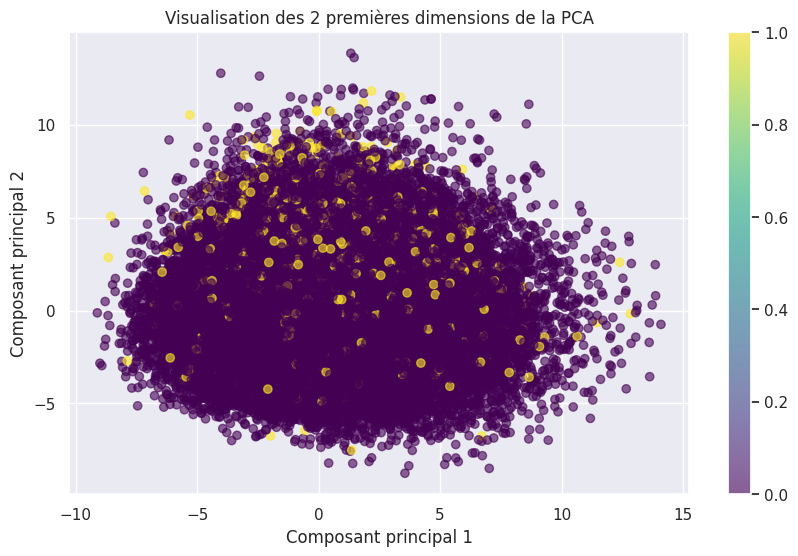

In [26]:
x_pca_2d = pca.transform(x_train_scaled)[:, :2]

plt.figure(figsize=(10, 6))
plt.scatter(x_pca_2d[:, 0], x_pca_2d[:, 1], c=y_train, cmap='viridis', alpha=0.6)
plt.xlabel("Composant principal 1")
plt.ylabel("Composant principal 2")
plt.colorbar(label='')
plt.title("Visualisation des 2 premières dimensions de la PCA")
plt.show()


### Equilibrer les classes dans les données d'entrainement

Vu le déséquilibre entre les classes à prédire (survive, died), on peut espérer améliorer le score en les rééquilibrant.

In [27]:
unique_counts = y_train.value_counts()
print(unique_counts)

0    53992
1     2007
Name: count, dtype: int64


In [28]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
x_train, y_train = smote.fit_resample(x_train, y_train)

## 5. Modèles de classification

In [29]:
SCORINGS = "balanced_accuracy"

In [30]:
from sklearn.linear_model import LogisticRegression


model = LogisticRegression(solver='liblinear', max_iter=1000)

model.fit(x_train, y_train) 


LogisticRegression(max_iter=1000, solver='liblinear')

## 6. Évaluations

La métrique sklearn.metrics.balanced_accuracy_score est utilisée plutôt que sklearn.metrics.accuracy_score car elle prend en compte les déséquilibres entre les classes. Dans le cas où la distribution des classes est inégale (par exemple, un nombre beaucoup plus élevé de survivants que de décès), l'accuracy_score peut donner une impression trompeuse de bonne performance du modèle.

La balanced_accuracy_score calcule la moyenne des rappels (ou sensibilités) obtenus pour chaque classe, en tenant compte de leur répartition. Cette métrique est plus adaptée pour évaluer les performances d'un modèle lorsque les classes sont déséquilibrées, car elle donne un poids égal à chaque classe, indépendamment de leur fréquence.

In [31]:
y_pred = model.predict(x_valid)  # predictions

score = metrics.balanced_accuracy_score(y_valid, y_pred)  # scoring

print(f"Balanced accuracy score: {score:.3g}")

Balanced accuracy score: 0.539


### Code : Validation croisée

Utilisation la validation croisée (pour obtenir une estimation plus fiable) combinée à l'exploration des hyperparamètres (pour améliorer les résultats).

In [39]:
from sklearn.model_selection import GridSearchCV


# Définition des hyperparamètres à explorer
param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'newton-cg', 'sag'],
    'max_iter': [10, 100, 1000]
}


# Création du modèle de régression logistique
logreg = LogisticRegression()

# Création de l'objet GridSearchCV avec le modèle et les paramètres à explorer
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='balanced_accuracy', n_jobs=-1)
grid_search2 = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Entraînement du modèle avec la recherche des meilleurs hyperparamètres
grid_search.fit(x_train, y_train)
grid_search2.fit(x_train, y_train)

# Affichage des meilleurs hyperparamètres
print("Meilleurs hyperparamètres trouvés pour le balanced accuracy score : ", grid_search.best_params_)
print("Meilleurs hyperparamètres trouvés pour le roc_auc score : ", grid_search2.best_params_)

# Utilisation du modèle avec les meilleurs hyperparamètres pour faire des prédictions
best_logreg = grid_search.best_estimator_


/home/karim/miniconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/karim/miniconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/karim/miniconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/karim/miniconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/karim/miniconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/karim/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: Convergen

Meilleurs hyperparamètres trouvés pour le balanced accuracy score :  {'C': 10, 'max_iter': 100, 'solver': 'newton-cg'}
Meilleurs hyperparamètres trouvés pour le roc_auc score :  {'C': 0.1, 'max_iter': 100, 'solver': 'newton-cg'}


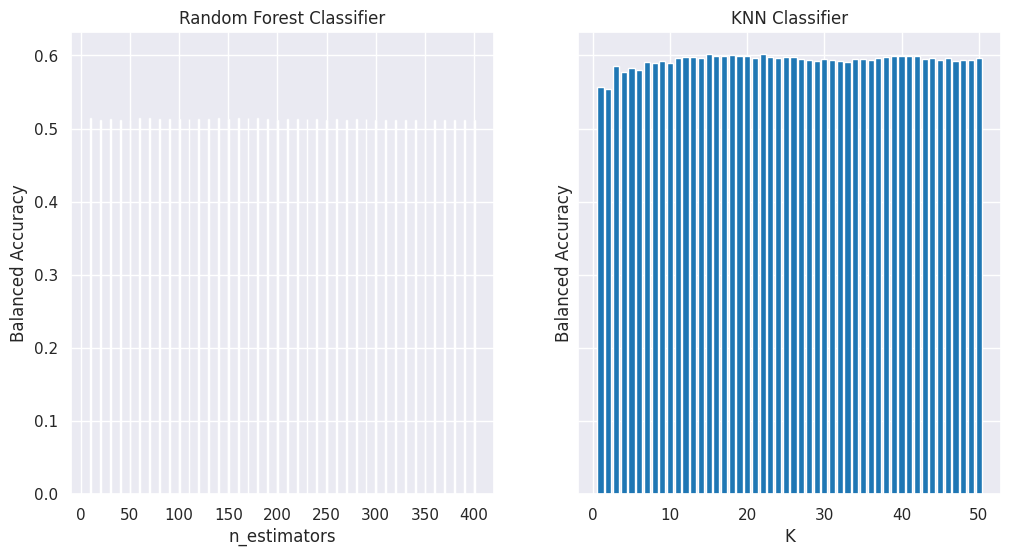

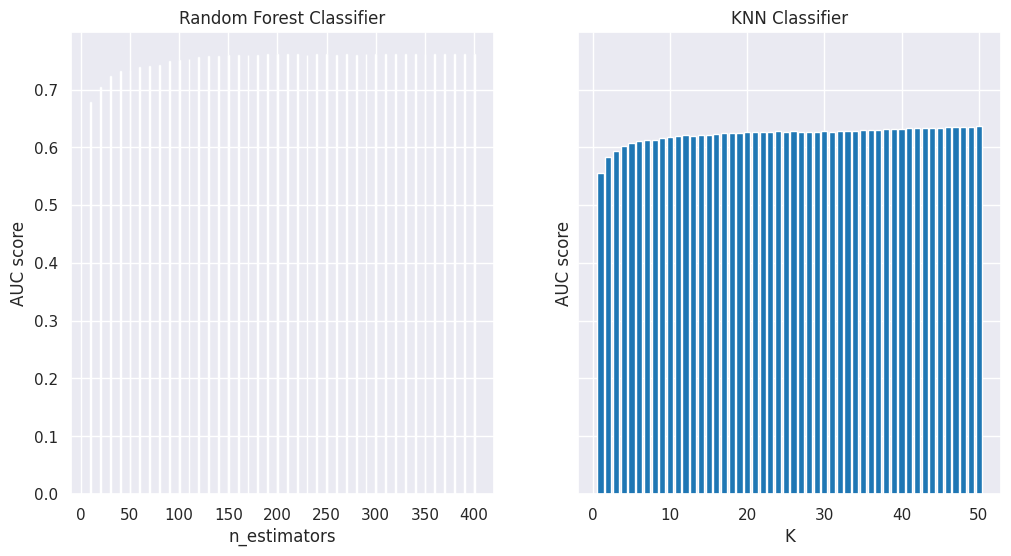

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score


# Choix des hyperparamètres
n_estimators_values = range(10, 410, 10)  # Pour le classificateur Random Forest
k_values = range(1, 51)  # Pour le classificateur KNN

# Stockage des résultats
rf_scores = []
knn_scores = []

rf_auc_scores = []
knn_auc_scores = []


# Calcul des scores pour les différents hyperparamètres sans utiliser cross-validation
for n_estimators in n_estimators_values:
    rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42, n_jobs=-1)
    rf.fit(x_train, y_train)
    rf_scores.append(metrics.balanced_accuracy_score(y_valid, rf.predict(x_valid)))
    rf_auc_scores.append(roc_auc_score(y_valid, rf.predict_proba(x_valid)[:, 1]))

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn.fit(x_train, y_train)
    knn_scores.append(metrics.balanced_accuracy_score(y_valid, knn.predict(x_valid)))
    knn_auc_scores.append(roc_auc_score(y_valid, knn.predict_proba(x_valid)[:, 1]))

# Conversion des listes en tableaux numpy pour le calcul des moyennes et écarts-types
rf_scores = np.array(rf_scores)
knn_scores = np.array(knn_scores)

rf_auc_scores = np.array(rf_auc_scores)
knn_auc_scores = np.array(knn_auc_scores)

# Création des diagrammes à bâtons
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

axes[0].bar(n_estimators_values, rf_scores, capsize=5)
axes[0].set_title("Random Forest Classifier")
axes[0].set_xlabel("n_estimators")
axes[0].set_ylabel("Balanced Accuracy")

axes[1].bar(k_values, knn_scores, capsize=5)
axes[1].set_title("KNN Classifier")
axes[1].set_xlabel("K")
axes[1].set_ylabel("Balanced Accuracy")

plt.show()



fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

axes[0].bar(n_estimators_values, rf_auc_scores, capsize=5)
axes[0].set_title("Random Forest Classifier")
axes[0].set_xlabel("n_estimators")
axes[0].set_ylabel("AUC score")

axes[1].bar(k_values, knn_auc_scores, capsize=5)
axes[1].set_title("KNN Classifier")
axes[1].set_xlabel("K")
axes[1].set_ylabel("AUC score")

plt.show()

Dans cet exemple, J'ai utiliséle classificateur randomforest  et le classificateur KNN pour comparer les balanced_accuracy moyennes de la validation croisée pour différentes valeurs d'hyperparamètres. J'ai affiché les résultats avec un diagramme à bâtons avec des barres d'erreur.

In [46]:
best_n_estimator_bas = k_values[np.argmax(rf_scores)]
best_k_bas = k_values[np.argmax(knn_scores)]
print(f"Meilleur nombre d'estimateurs pour le classificateur Random Forest pour balanced accuracy score : {best_n_estimator_bas}")
print(f"Meilleur nombre de voisins pour le classificateur KNN pour balanced accuracy score: {best_k_bas}")

best_n_estimator_auc = k_values[np.argmax(rf_auc_scores)]
best_k_auc = k_values[np.argmax(knn_auc_scores)]
print(f"Meilleur nombre d'estimateurs pour le classificateur Random Forest pour AUC score : {best_n_estimator_auc}")
print(f"Meilleur nombre de voisins pour le classificateur KNN pour AUC score: {best_k_auc}")


Meilleur nombre d'estimateurs pour le classificateur Random Forest pour balanced accuracy score : 1
Meilleur nombre de voisins pour le classificateur KNN pour balanced accuracy score: 15
Meilleur nombre d'estimateurs pour le classificateur Random Forest pour AUC score : 31
Meilleur nombre de voisins pour le classificateur KNN pour AUC score: 50


In [47]:
from sklearn.metrics import roc_auc_score
# Entraîner les modèles avec les meilleurs hyperparamètres trouvés précédemment


best_rf_bas = RandomForestClassifier(n_estimators= best_n_estimator_bas, random_state=42, n_jobs=-1)  
best_knn_bas = KNeighborsClassifier(n_neighbors = best_k_bas, n_jobs=-1)
best_logreg_bas = grid_search.best_estimator_


best_rf_auc = RandomForestClassifier(n_estimators= best_n_estimator_auc, random_state=42, n_jobs=-1)
best_knn_auc = KNeighborsClassifier(n_neighbors = best_k_auc, n_jobs=-1)
best_logreg_auc = grid_search2.best_estimator_

# Entraîner les modèles sur les données d'entraînement
best_rf_bas.fit(x_train, y_train)
best_knn_bas.fit(x_train, y_train)
best_logreg_bas.fit(x_train, y_train)

best_rf_auc.fit(x_train, y_train)
best_knn_auc.fit(x_train, y_train)
best_logreg_auc.fit(x_train, y_train)


#Prédire les valeurs de la variable cible sur les données de validation
rf_pred = best_rf_bas.predict(x_valid)
knn_pred = best_knn_bas.predict(x_valid)
logreg_pred = best_logreg_bas.predict(x_valid)

rf_score = metrics.balanced_accuracy_score(y_valid, rf_pred)  # scoring
knn_score = metrics.balanced_accuracy_score(y_valid, knn_pred)  # scoring
logreg_score = metrics.balanced_accuracy_score(y_valid, logreg_pred)  # scoring

rf_score_auc = metrics.roc_auc_score(y_valid, best_rf_auc.predict_proba(x_valid)[:, 1])
knn_score_auc = metrics.roc_auc_score(y_valid, best_knn_auc.predict_proba(x_valid)[:, 1])
logreg_score_auc = metrics.roc_auc_score(y_valid, best_logreg_auc.predict_proba(x_valid)[:, 1])

# Afficher les résultats
print(f"Balanced accuracy score of the best Random Forest model: {rf_score:.3g}")
print(f"Balanced accuracy score of the best KNN model: {knn_score:.3g}")
print(f"Balanced accuracy score of the best LogisticRegression model: {logreg_score:.3g}")
print("\n")
print(f"AUC score of the best Random Forest model: {rf_score_auc:.3g}")
print(f"AUC score of the best KNN model: {knn_score_auc:.3g}")
print(f"AUC score of the best LogisticRegression model: {logreg_score_auc:.3g}")



Balanced accuracy score of the best Random Forest model: 0.548
Balanced accuracy score of the best KNN model: 0.602
Balanced accuracy score of the best LogisticRegression model: 0.536


AUC score of the best Random Forest model: 0.725
AUC score of the best KNN model: 0.636
AUC score of the best LogisticRegression model: 0.796


### Choix du Modèle

- **Si l'équilibre entre les classes est crucial** et que la capacité à bien performer sur les deux classes (décès et non-décès) est la priorité, **le modèle KNN** pourrait être préféré en raison de son score de précision équilibrée supérieur.
- **Cependant, si la capacité à distinguer précisément entre les patients qui décéderont et ceux qui ne le feront pas est plus importante**, ce qui est souvent le cas dans les contextes médicaux où minimiser les faux positifs et faux négatifs est crucial, **le modèle de régression logistique** est nettement le meilleur choix, en raison de son score AUC très supérieur.

---

# Remarque sur le jeu de données

Le jeu de données ne contient pas de données médicales réelles. Nous ne sommes pas autorisés à partager ces **données confidentielles** provenant de patient·e·s en soins intensifs. Pour éviter ce problème, les données ont été remplacées par des **données artificielles**.

Afin d'avoir des données crédibles, elles ont été générées à l'aide d'un réseau adverse génératif (**GAN**) Wasserstein.

Pour plus d'informations, voici une référence : <br />
[Privacy Preserving Synthetic Health Data](https://hal.inria.fr/hal-02160496/document) <br />
Andrew Yale, Saloni Dash, Ritik Dutta, Isabelle Guyon, Adrien Pavao, Kristin Bennett <br />

---